<a href="https://colab.research.google.com/github/yeshg11/Stock-market-prediction-using-LSTM/blob/main/Microsoft_Stock_Forecasting_with_LSTMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# dataset @ https://finance.yahoo.com/quote/MSFT/history/


In [ ]:
import pandas as pd

df = pd.read_csv('MSFT.csv')

df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060274,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062427,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063504,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061889,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060812,47894400
...,...,...,...,...,...,...,...
9535,2024-01-12,385.489990,388.679993,384.649994,388.470001,388.470001,21645700
9536,2024-01-16,393.660004,394.029999,387.619995,390.269989,390.269989,27202300
9537,2024-01-17,387.980011,390.109985,384.809998,389.470001,389.470001,22234100
9538,2024-01-18,391.720001,393.989990,390.119995,393.869995,393.869995,23392100


In [ ]:
df = df[['Date', 'Close']]
df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9535,2024-01-12,388.470001
9536,2024-01-16,390.269989
9537,2024-01-17,389.470001
9538,2024-01-18,393.869995


In [ ]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)


In [ ]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']
df.index=df.pop('Date')
df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2024-01-12,388.470001
2024-01-16,390.269989
2024-01-17,389.470001


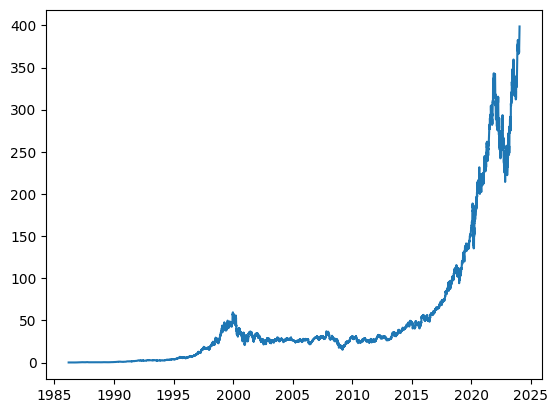

In [ ]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [ ]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]
    dates.append(target_date)
    X.append(x)
    Y.append(y)
    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  X = np.array(X)
  for i in range(0, n):
    ret_df[f'Target-{n-i}'] = X[:, i]
  ret_df['Target'] = Y

  return ret_df
windowed_df = df_to_windowed_df(df,
                                '2021-01-4',
                                '2024-01-4',
                                n=2)
windowed_df

,Target Date,Target-2,Target-1,Target
0,2021-01-04,221.679993,222.419998,217.690002
1,2021-01-05,222.419998,217.690002,217.899994
2,2021-01-06,217.690002,217.899994,212.250000
3,2021-01-07,217.899994,212.250000,218.289993
4,2021-01-08,212.250000,218.289993,219.619995
...,...,...,...,...
751,2023-12-28,374.660004,374.070007,375.279999
752,2023-12-29,374.070007,375.279999,376.040009
753,2024-01-02,375.279999,376.040009,370.869995
754,2024-01-03,376.040009,370.869995,370.600006


In [ ]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()
  dates = df_as_np[:, 0]
  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape(len(dates), middle_matrix.shape[1], 1)
  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)


(756, 2)
[[[221.679993]
  [222.419998]]

 [[222.419998]
  [217.690002]]

 [[217.690002]
  [217.899994]]

 ...

 [[375.279999]
  [376.040009]]

 [[376.040009]
  [370.869995]]

 [[370.869995]
  [370.600006]]]


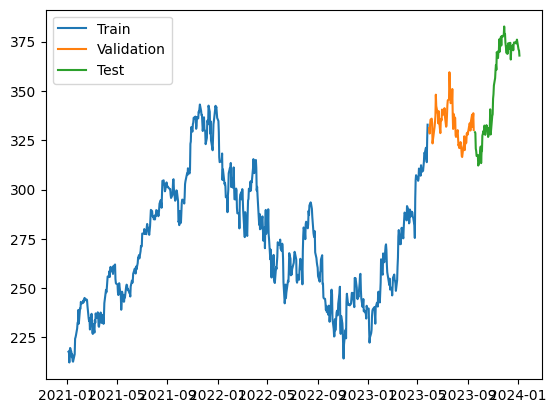

In [ ]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((2, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150)

Epoch 1/150
19/19 [==============================] - 4s 40ms/step - loss: 75204.8125 - mean_absolute_error: 272.4518 - val_loss: 110841.1719 - val_mean_absolute_error: 332.8185
Epoch 2/150
19/19 [==============================] - 0s 8ms/step - loss: 74755.2969 - mean_absolute_error: 271.6255 - val_loss: 109734.0625 - val_mean_absolute_error: 331.1511
Epoch 3/150
19/19 [==============================] - 0s 8ms/step - loss: 72436.4609 - mean_absolute_error: 267.3036 - val_loss: 103126.0312 - val_mean_absolute_error: 321.0183
Epoch 4/150
19/19 [==============================] - 0s 8ms/step - loss: 58046.7031 - mean_absolute_error: 238.2638 - val_loss: 66344.2188 - val_mean_absolute_error: 257.4304
Epoch 5/150
19/19 [==============================] - 0s 7ms/step - loss: 14666.8076 - mean_absolute_error: 99.9945 - val_loss: 313.5417 - val_mean_absolute_error: 15.5308
Epoch 6/150
19/19 [==============================] - 0s 7ms/step - loss: 2048.6765 - mean_absolute_error: 36.9401 - val_loss:

19/19 [==============================] - 1s 4ms/step


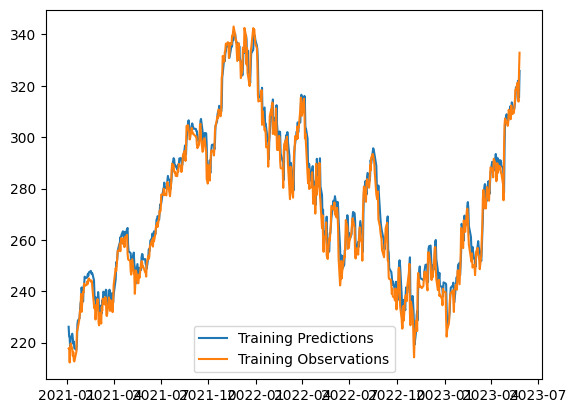

In [ ]:
train_predictions = model.predict(X_train).flatten()
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

3/3 [==============================] - 0s 5ms/step


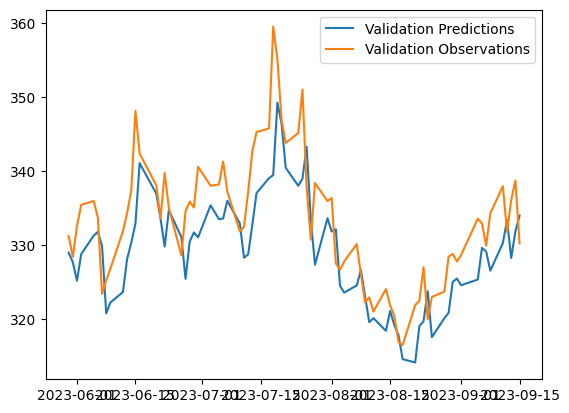

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

3/3 [==============================] - 0s 6ms/step - loss: 132.0217 - mean_absolute_error: 9.6214


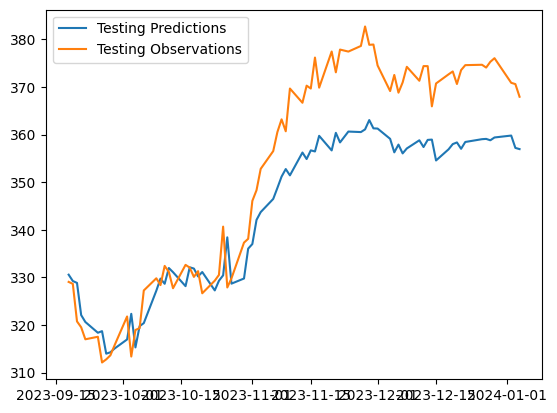

In [ ]:
test_predictions = model.predict(X_test).flatten()
test_loss, test_accuracy = model.evaluate(X_test, y_test)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

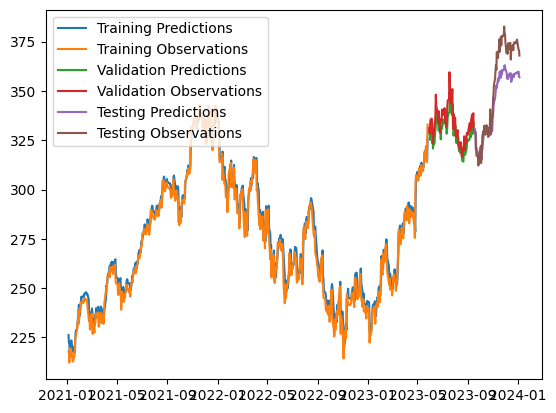

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

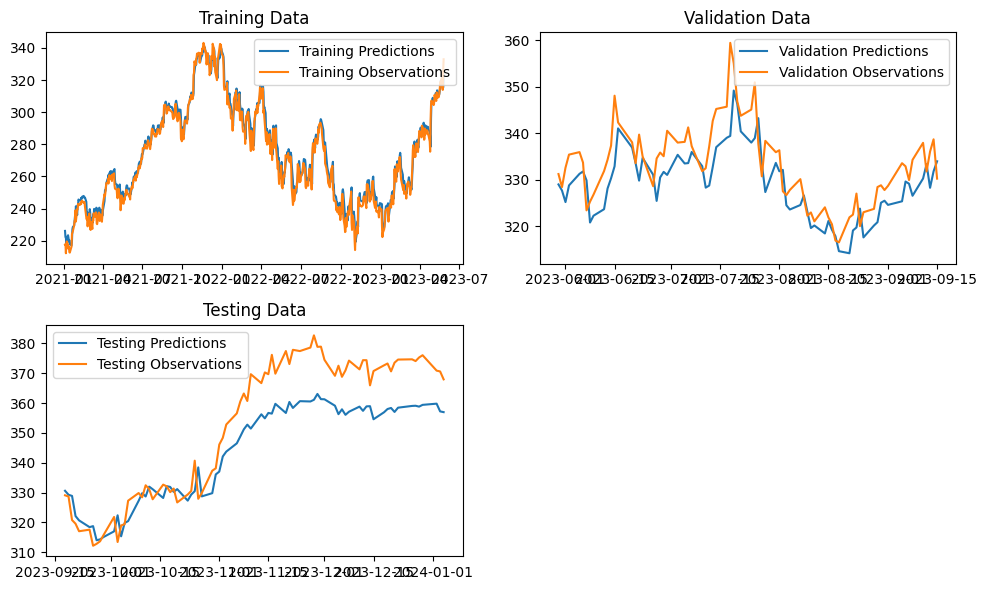

In [ ]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.plot(dates_train, train_predictions, label='Training Predictions')
plt.plot(dates_train, y_train, label='Training Observations')
plt.title("Training Data")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(dates_val, val_predictions, label='Validation Predictions')
plt.plot(dates_val, y_val, label='Validation Observations')
plt.title("Validation Data")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(dates_test, test_predictions, label='Testing Predictions')
plt.plot(dates_test, y_test, label='Testing Observations')
plt.title("Testing Data")
plt.legend()
plt.tight_layout()  # Adjust spacing for better visibility
plt.show()

In [ ]:
custom_input = np.array([[234],[654]])  # Shape (2, 1)
print(custom_input.shape)
predictions = model.predict(custom_input)
print(predictions)

(2, 1)
1/1 [==============================] - 0s 482ms/step
[[2.844213]
 [2.844213]]
